In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Basic Ideas:

Spacing as a geometric series:

    dx = a * r ^ 1.05

Position is a cumulative sum of the series:

    x[k] = a * (1 - r ^ k) / (1 - r)


Reverse lookup:

    k = 1 / log(r) * log(1 - (1 - r) / a * z[k])
      = 1 / log(r) * log(1 + (r - 1) / a * z[k])

NOTE: We can use the math function `log1p()` in OpenCL

## Some Excerpts from the SimRadar Source Code

```c
void RS_set_vel_data_to_LES_table() ...
...
table.spacing = RSTableSpacingStretchedX | RSTableSpacingStretchedY | RSTableSpacingStretchedZ;
table.x_ = leslie->nx;
table.xm = 0.5f * (float)(leslie->nx - 1);
table.xs = 1.0f / log(leslie->rx);
table.xo = (leslie->rx - 1.0f) / leslie->ax;

table.y_ = leslie->ny;
table.ym = 0.5f * (float)(leslie->ny - 1);
table.ys = 1.0f / log(leslie->ry);
table.yo = (leslie->ry - 1.0f) / leslie->ay;

table.z_ = leslie->nz;
table.zm = 0.0f;
table.zs = 1.0f / log(leslie->rz);
table.zo = (leslie->rz - 1.0f) / leslie->az;


void RS_set_vel_data() ...
...
H->workers[i].les_desc.s[RSTable3DStaggeredDescriptionBaseChangeX] = table.xs;
H->workers[i].les_desc.s[RSTable3DStaggeredDescriptionPositionScaleX] = table.xo;
H->workers[i].les_desc.s[RSTable3DStaggeredDescriptionOffsetX] = table.xm;


int4 wind_table_index() ...
...
float4 pos_rel = pos - (float4)(sim_desc.hi.s01 + 0.5f * sim_desc.hi.s45, 0.0f, 0.0f);
return copysign(wind_desc.s0123, pos_rel) * log1p(wind_desc.s4567 * fabs(pos_rel)) + wind_desc.s89ab;

#  k = (     m    ) * log1p((    n    ) * z[k]) + (     o      )
#  k = 1.0 / log(r) * log1p((r - 1) / a * z[k]) + (0.5 * nx - 1)
```

In [3]:
# Stretched grid with a = 2.0, r = 1.0212
a = 2.0
# r = 1.0212
r = 1.3

n = 9                      # Number of total grids
m = 0.5 * (n - 1)          # Number of grids on each side (half)
s = 1.0 / np.log(r)        # Scaling factor
o = (r - 1.0) / a          # Offset

s0 = s                     # s0123 for scale of x, y, z, _
s4 = o                     # s4567 for log1p() of x, y, z, _
s8 = m                     # s89ab for half-count of x, y, z, _

In [4]:
# Exapmle position to index for table lookup
x = -6.0
k = s0 * np.sign(x) * np.log1p(s4 * np.abs(x)) + s8
print('x = {} --> k = {:.2f}'.format(x, k))

x = -6.0 --> k = 1.55


In [5]:
np.set_printoptions(formatter={'float': ' {:6.3f}'.format})

In [6]:
k = np.arange(0, m + 1)
x = a * (1.0 - np.power(r, k)) / (1.0 - r)
dx = np.concatenate(([0], a * np.power(r, k[:-1])))

print('         k = {}'.format(np.array(k, dtype=float)))
print('        dx = {}'.format(dx))
print('cumsum(dx) = {}'.format(np.cumsum(dx)))
print('         x = {}'.format(x))

         k = [  0.000   1.000   2.000   3.000   4.000]
        dx = [  0.000   2.000   2.600   3.380   4.394]
cumsum(dx) = [  0.000   2.000   4.600   7.980  12.374]
         x = [ -0.000   2.000   4.600   7.980  12.374]


In [7]:
k = np.array(np.arange(-m, m+1), dtype=float)
i = np.array(np.arange(len(k)), dtype=float)
x = np.sign(k) * a * (1.0 - np.power(r, np.abs(k))) / (1.0 - r)
dx = a * np.power(r, np.abs(k))

# Compute the table index
k0 = s0 * np.sign(x) * np.log1p(s4 * np.abs(x)) + s8

In [8]:
print(' i = {}'.format(i))
print(' k = {}'.format(k))
print(' x = {}'.format(x))
print('dx = {}'.format(dx))
print('')
print('k0 = {}'.format(k0))

 i = [  0.000   1.000   2.000   3.000   4.000   5.000   6.000   7.000   8.000]
 k = [ -4.000  -3.000  -2.000  -1.000   0.000   1.000   2.000   3.000   4.000]
 x = [ -12.374  -7.980  -4.600  -2.000  -0.000   2.000   4.600   7.980  12.374]
dx = [  5.712   4.394   3.380   2.600   2.000   2.600   3.380   4.394   5.712]

k0 = [ -0.000   1.000   2.000   3.000   4.000   5.000   6.000   7.000   8.000]


In [13]:
xx, yy  = np.meshgrid(x, x)
f = np.exp(-(xx - 2) ** 2 / 40 - (yy + 4.0) ** 2 / 40 - (xx - 2) * (yy + 4.0) / 30)
pdf = f / f.sum()
cdf = pdf.cumsum()

fx = np.arange(1, n * n + 1) / (n * n)

count = 10000
rr = np.random.rand(count)
ii = np.interp(rr, cdf, fx)
ii = ii * (n * n)

ix = np.remainder(ii, n) - m
iy = np.floor(ii / n) + np.random.rand(count) - m

vx = np.sign(ix) * a * (1.0 - np.power(r, np.abs(ix))) / (1.0 - r)
vy = np.sign(iy) * a * (1.0 - np.power(r, np.abs(iy))) / (1.0 - r)

# Compute the 2D histogram
H, _, _ = np.histogram2d(vx, vy, bins=(x, x))
H = H.T

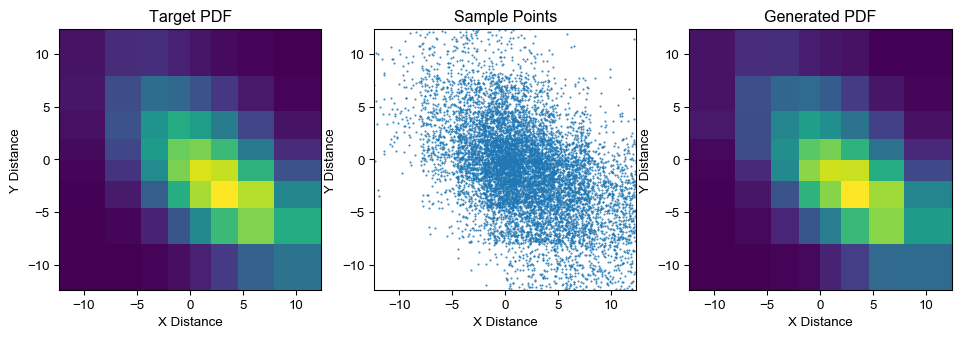

In [14]:
plt.figure(figsize=(12,3.6), dpi=96)

plt.subplot(131)
plt.pcolor(xx, yy, pdf)
_ = plt.xlabel('X Distance')
_ = plt.ylabel('Y Distance')
_ = plt.title('Target PDF')

plt.subplot(132)
plt.plot(vx, vy, '.', markersize=1)
_ = plt.xlim(x[0], x[-1])
_ = plt.ylim(x[0], x[-1])
_ = plt.xlabel('X Distance')
_ = plt.ylabel('Y Distance')
_ = plt.title('Sample Points')

plt.subplot(133)
plt.pcolor(xx, yy, H / H.max())
_ = plt.xlim(x[0], x[-1])
_ = plt.ylim(x[0], x[-1])
_ = plt.xlabel('X Distance')
_ = plt.ylabel('Y Distance')
_ = plt.title('Generated PDF')